# Task 4: Group Task

### Spain as country

In [113]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import cartopy as cp
import cartopy.crs as ccrs
from atlite.gis import ExclusionContainer
from atlite.gis import shape_availability
from rasterio.plot import show
from shapely.ops import unary_union
import rasterio
import atlite

In [ ]:
file = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=country_shapes.geojson"
shapes = gpd.read_file(file).set_index('name')

In [30]:
spain = shapes.query("index == 'ES'").to_crs(3035).geometry
spain.explore()

In [24]:
regions = "https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgadm&files=gadm_410-levels-ADM_1-ESP.gpkg"
regions = gpd.read_file(regions)

In [40]:
regions

,GID_0,GID_1,COUNTRY,NAME_1,geometry
0,ESP,ESP.1_1,Spain,Andalucía,"MULTIPOLYGON (((3140224.434 1531298.763, 31402..."
1,ESP,ESP.2_1,Spain,Aragón,"MULTIPOLYGON (((3394510.470 1933341.623, 33948..."
2,ESP,ESP.3_1,Spain,Cantabria,"MULTIPOLYGON (((3186946.783 2305680.547, 31868..."
3,ESP,ESP.4_1,Spain,Castilla-La Mancha,"MULTIPOLYGON (((3320725.971 1797144.007, 33194..."
4,ESP,ESP.5_1,Spain,Castilla y León,"MULTIPOLYGON (((2995681.931 2042242.654, 29957..."
5,ESP,ESP.6_1,Spain,Cataluña,"MULTIPOLYGON (((3509568.598 1990154.551, 35094..."
6,ESP,ESP.7_1,Spain,Ceuta y Melilla,"MULTIPOLYGON (((3181474.918 1439885.947, 31815..."
7,ESP,ESP.8_1,Spain,Comunidad de Madrid,"MULTIPOLYGON (((3135875.888 1977029.997, 31356..."
8,ESP,ESP.9_1,Spain,Comunidad Foral de Navarra,"MULTIPOLYGON (((3359007.179 2167900.746, 33586..."
9,ESP,ESP.10_1,Spain,Comunidad Valenciana,"MULTIPOLYGON (((3371696.650 1712113.228, 33716..."


### create 5 zones for the analysis:

In [106]:
zone1 = regions.drop(range(1,17))
zone1 = unary_union(zone1.geometry)

#comunidad valencia, castilla la mancha, extremadura, madrid
zone2 = regions.drop([0,1,2,4,5,6,8,11,12,13,14,15,16,17])
zone2 = unary_union(zone2.geometry)

#cataluna und aragon
zone3 = regions.drop([0,2,3,4,6,7,8,9,10,11,12,13,14,15,16,17])
zone3 = unary_union(zone3.geometry)

#8,14,15,4,16,2
zone4 = regions.drop([0,1,3,5,6,7,9,10,11,12,13,17])
zone4 = unary_union(zone4.geometry)

zone5 = regions.drop([0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17])
zone5 = unary_union(zone5.geometry)

geometries = [zone1,zone2,zone3,zone4,zone5]
names = ['zone_1','zone_2','zone_3','zone_4','zone_5',]


In [122]:
zones = gpd.GeoDataFrame(names, geometry = geometries)
zones['center'] = zones.geometry.centroid

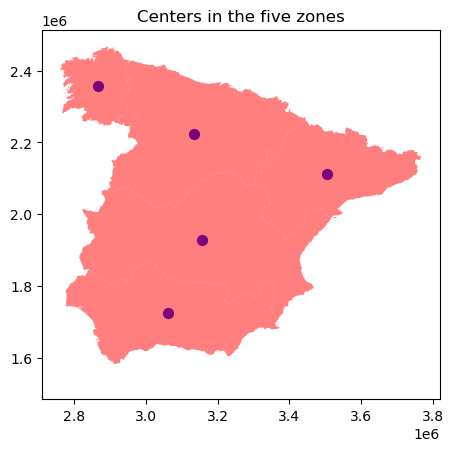

In [123]:
fig, ax = plt.subplots()

# Plot the points
zones.center.plot(ax=ax, color='blue', markersize=50)
point_color = (1, 0, 0, 0.5)
zones.geometry.plot(ax=ax, color=point_color )
ax.set_title("Centers in the five zones")

# Display the plot
plt.show()

### First, perform a land eligibility analysis
- onshore wind:
- 10km distance to airports
- 300m distance to major roads
- no natural protection areas
- maximum elevation of 2000m
- 1000m distance to built up areas
- only on suitable land cover classes

In [144]:
file_roads = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_roads.gpkg'
file_airport = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2F&files=ne_10m_airports.gpkg'
file_clases = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fcopernicus-glc&files=PROBAV_LC100_global_v3.0.1_2019-nrt_Discrete-Classification-map_EPSG-4326-ES.tif'
file_elevation = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fgebco&files=GEBCO_2014_2D-ES.nc'
file_protected = 'https://tubcloud.tu-berlin.de/s/567ckizz2Y6RLQq/download?path=%2Fwdpa&files=WDPA_Oct2022_Public_shp-ESP.tif'
area = spain

In [156]:
roads = gpd.read_file(file_roads)

In [161]:
road = roads.geometry
#hier gibts kein spanien?!

In [134]:
#exclude roads and airports:
excluder = ExclusionContainer(crs=3035)
clc = rasterio.open(file_clases)
band = clc.read()

In [162]:
excluder.add_geometry(road)
band, transform = shape_availability(area, excluder)
fig, ax = plt.subplots(figsize=(4,5))
zones.plot(ax=ax, color='none')
show(band, transform=transform, cmap='Greens', ax=ax)

DriverError: '/vsimem/f0fae9808cc948eda60002f929d08c17' not recognized as a supported file format.

In [ ]:
#4. exclusion of a buffer of 300m next to major roads
excluder_4 = ExclusionContainer(crs=3035)
excluder_4.add_geometry(lux, invert = True)
excluder_4.add_geometry(name4, buffer = 300)
band, transform = shape_availability(lux, excluder_4)
fig, ax = plt.subplots(figsize=(4,5))
lux.plot(ax=ax, color='none')
show(band, transform=transform, cmap='Greens', ax=ax)

In [ ]:
#exclude roads and airports:
excluder = ExclusionContainer(crs=3035)

#load clases
clc = rasterio.open(file_clases)
band = clc.read(1)
country_area = lux.geometry.area[0]*(1/1e6)

#add geometry for vector data
#1. exclusion of natural protection areas
excluder.add_geometry(name1)
band, transform = shape_availability(lux, excluder)
fig, ax = plt.subplots(figsize=(4,5))
lux.plot(ax=ax, color='none')
show(band, transform=transform, cmap='Greens', ax=ax)
#calculate rest of area:
eligible_cells = band.sum()
cell_area = excluder.res**2*(1/1e6)
eligible_area = cell_area * eligible_cells
ex_1 = eligible_area / country_area * 100 
